Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 1805, number of used features: 12
[LightGBM] [Info] Start training from score 4954797.783934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/tmp/ipython-input-2755649826.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-2755649826.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

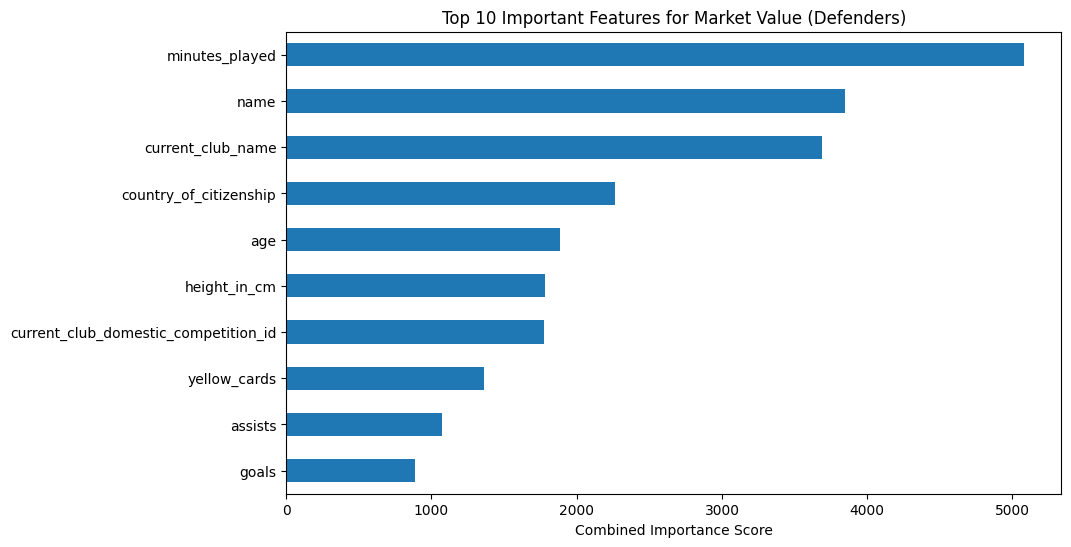


💾 Models and encoders saved successfully to Google Drive!

💰 Predicted Market Value for John Doe: €28,568,944


In [16]:
# ============================================
# Football Player Market Value Prediction (Defenders)
# Using LightGBM + XGBoost Ensemble (No Negative Values)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from google.colab import drive
import joblib  # ✅ for saving models efficiently

# Mount Google Drive
drive.mount('/content/drive')

# ============================================
# Step 1: Load Dataset
# ============================================
file_path = "/content/drive/MyDrive/defenders_only_fixed_2023.csv"  # Update if needed
df = pd.read_csv(file_path)

# ============================================
# Step 2: Filter for Defenders
# ============================================
df = df[df['position'].str.contains('Defender', case=False, na=False)]

# ============================================
# Step 3: Select Relevant Columns
# ============================================
cols = [
    'name', 'country_of_citizenship', 'position', 'foot', 'height_in_cm',
    'current_club_domestic_competition_id', 'current_club_name',
    'market_value_in_eur', 'yellow_cards', 'red_cards',
    'goals', 'assists', 'minutes_played', 'age'
]
df = df[cols].copy()

# ============================================
# Step 4: Handle Missing Values
# ============================================
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# ============================================
# Step 5: Label Encode Categorical Columns
# ============================================
categorical_cols = [
    'name', 'country_of_citizenship', 'position', 'foot',
    'current_club_domestic_competition_id', 'current_club_name'
]

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# ============================================
# Step 6: Split Data
# ============================================
X = df.drop(columns=['market_value_in_eur'])
y = df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Step 7: LightGBM Model
# ============================================
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=12,
    num_leaves=60,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# ============================================
# Step 8: XGBoost Model
# ============================================
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_lambda=1,
    tree_method='hist'
)
xgb_model.fit(X_train, y_train)

# ============================================
# Step 9: Ensemble Predictions (with Clipping)
# ============================================
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred = 0.6 * y_pred_lgb + 0.4 * y_pred_xgb

# ✅ Clip negative predictions to zero
y_pred = np.clip(y_pred, 0, None)

# ============================================
# Step 10: Evaluate Model
# ============================================
print("\n⚽ Combined LightGBM + XGBoost Model Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

# ============================================
# Step 10.1: Analyze Prediction Errors
# ============================================
results_df = X_test.copy()
results_df['Actual_Value'] = y_test.values
results_df['Predicted_Value'] = y_pred
results_df['Absolute_Error'] = abs(results_df['Actual_Value'] - results_df['Predicted_Value'])

# Decode player names for readability
results_df['Player_Name'] = encoders['name'].inverse_transform(results_df['name'])

# Sort by highest absolute error
top_errors = results_df.sort_values(by='Absolute_Error', ascending=False).head(5)
print("\n🔍 Top 5 Players with Highest Absolute Errors:")
print(top_errors[['Player_Name', 'Actual_Value', 'Predicted_Value', 'Absolute_Error']])

# ============================================
# Step 10.2: Save Results to CSV
# ============================================
results_df.to_csv("/content/drive/MyDrive/defenders_market_value_predictions.csv", index=False)
print("✅ File successfully saved to Google Drive: '/content/drive/MyDrive/defenders_market_value_predictions.csv'")

# ============================================
# Step 11: Feature Importance Visualization
# ============================================
importances_lgb = pd.Series(lgb_model.feature_importances_, index=X.columns)
importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)

combined_importance = (0.6 * importances_lgb + 0.4 * importances_xgb).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
combined_importance.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features for Market Value (Defenders)")
plt.xlabel("Combined Importance Score")
plt.show()

# ============================================
# Step 12: Save Models and Encoders (Pickle)
# ============================================

# Save both models
joblib.dump(lgb_model, "/content/drive/MyDrive/lgb_defender_model.pkl")
joblib.dump(xgb_model, "/content/drive/MyDrive/xgb_defender_model.pkl")

# Save encoders
joblib.dump(encoders, "/content/drive/MyDrive/defender_encoders.pkl")

print("\n💾 Models and encoders saved successfully to Google Drive!")

# ============================================
# Step 13: Predict for New Player
# ============================================
example_player = {
    'name': 'John Doe',
    'country_of_citizenship': 'England',
    'position': 'Centre-Back',
    'foot': 'Right',
    'height_in_cm': 185,
    'current_club_domestic_competition_id': 'GB1',
    'current_club_name': 'Chelsea FC',
    'yellow_cards': 4,
    'red_cards': 0,
    'goals': 2,
    'assists': 1,
    'minutes_played': 2200,
    'age': 27
}

new_df = pd.DataFrame([example_player])

# Encode categorical columns for the new player
for col in categorical_cols:
    le = encoders[col]
    if 'Unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Unknown')
    new_df[col] = new_df[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
    new_df[col] = le.transform(new_df[col])

# Predict using ensemble
pred_lgb = lgb_model.predict(new_df[X.columns])[0]
pred_xgb = xgb_model.predict(new_df[X.columns])[0]
predicted_value = 0.6 * pred_lgb + 0.4 * pred_xgb

# ✅ Clip negative prediction to 0
predicted_value = max(predicted_value, 0)

print(f"\n💰 Predicted Market Value for {example_player['name']}: €{predicted_value:,.0f}")
